# Libraries

In [1]:
import pandas as pd
from getpass import getuser
import numpy as np
from scipy.stats import ttest_rel, wilcoxon  
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get the current user's name
user = getuser()


# Load Data

In [3]:
# ---- EURO datasets ----
data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\uefa\eu\goals_eu_uefa.xlsx'
goals_eu_uefa = pd.read_excel(data_path)

data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\fifa\eu\goals_eu_fifa.xlsx'
goals_eu_fifa = pd.read_excel(data_path)

data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\uefa\eu\mbm_eu_uefa.xlsx'
mbm_eu_uefa = pd.read_excel(data_path)

data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\fifa\eu\mbm_eu_fifa.xlsx'
mbm_eu_fifa = pd.read_excel(data_path)

# ---- WORLD CUP datasets ----
data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\uefa\wc\goals_wc_uefa.xlsx'
goals_wc_uefa = pd.read_excel(data_path)

data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\fifa\wc\goals_wc_fifa.xlsx'
goals_wc_fifa = pd.read_excel(data_path)

data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\uefa\wc\mbm_wc_uefa.xlsx'
mbm_wc_uefa = pd.read_excel(data_path)

data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\fifa\wc\mbm_wc_fifa.xlsx'
mbm_wc_fifa = pd.read_excel(data_path)

# ---- Elo files ----
data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\in\elo_eu.xlsx'
elo_eu = pd.read_excel(data_path)

data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\in\elo_wc.xlsx'
elo_wc = pd.read_excel(data_path)

# ---- shock, suspense, surprise ----
data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\uefa\eu\tab_prob_eu_uefa.xlsx'
sss_eu = pd.read_excel(data_path)

data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\out\wiki\men\fifa\wc\tab_prob_fifa_wc.xlsx'
sss_wc= pd.read_excel(data_path)


In [4]:
# Dictionary of replacements
replacements = {
    "Republic of Ireland": "Ireland",
    "CIS": "Commonwealth of Independent States",
    "FR Yugoslavia": "Yugoslavia"
}

# List of all relevant DataFrames
datasets = [
    goals_eu_uefa, goals_eu_fifa, mbm_eu_uefa, mbm_eu_fifa,
    goals_wc_uefa, goals_wc_fifa, mbm_wc_uefa, mbm_wc_fifa
]

# Apply replacements to each dataset
for df in datasets:
    df['home_team'] = df['home_team'].replace(replacements)
    df['away_team'] = df['away_team'].replace(replacements)

# Optional: show one updated DataFrame
display(goals_eu_uefa)



,year,stage,date,time,goal_minute,half_time,home_team,away_team,scorer_team,new_top_teams,...,third_qualify,qualified_teams,qual_changed,qual_count,pts_diff,gls_diff,elo_home,elo_away,h2h,suspense
0,1984,Group 1,1984-06-19,20:30,0,NaN,NaN,NaN,NaN,"['France', 'Denmark']",...,0,"['France', 'Denmark']",0,0,0,-7,NaN,NaN,1,1
1,1984,Group 1,1984-06-19,20:30,26,1.0,Denmark,Belgium,Belgium,"['Belgium', 'France']",...,0,"['France', 'Belgium']",1,1,-2,5,1809.0,1898.0,1,1
2,1984,Group 1,1984-06-19,20:30,32,1.0,France,Yugoslavia,Yugoslavia,"['Belgium', 'France']",...,0,"['France', 'Belgium']",0,1,-2,5,1960.0,1890.0,1,1
3,1984,Group 1,1984-06-19,20:30,39,1.0,Denmark,Belgium,Belgium,"['Belgium', 'France']",...,0,"['France', 'Belgium']",0,1,-2,3,1809.0,1898.0,1,0
4,1984,Group 1,1984-06-19,20:30,41,1.0,Denmark,Belgium,Denmark,"['Belgium', 'France']",...,0,"['France', 'Belgium']",0,1,-2,5,1809.0,1898.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,2024,Group F,2024-06-26,21:00,2,1.0,Georgia,Portugal,Georgia,"['Georgia', 'Turkey', 'Portugal']",...,1,"['Portugal', 'Turkey', 'Georgia']",1,1,-2,0,1666.0,2002.0,0,1
266,2024,Group F,2024-06-26,21:00,51,2.0,Czech Republic,Turkey,Turkey,"['Georgia', 'Turkey', 'Portugal']",...,1,"['Portugal', 'Turkey', 'Georgia']",0,1,-3,-1,1777.0,1749.0,0,0
267,2024,Group F,2024-06-26,21:00,57,2.0,Georgia,Portugal,Georgia,"['Georgia', 'Turkey', 'Portugal']",...,1,"['Portugal', 'Turkey', 'Georgia']",0,1,-3,-2,1666.0,2002.0,0,0
268,2024,Group F,2024-06-26,21:00,66,2.0,Czech Republic,Turkey,Czech Republic,"['Georgia', 'Turkey', 'Portugal']",...,1,"['Portugal', 'Turkey', 'Georgia']",0,1,-2,-1,1777.0,1749.0,0,1


# aggregate measure for elo, suspense, and changes

In [5]:
def compute_aggregated_metrics(goals_df, elo_df):
    """
    Merges Elo ratings for home and away teams, computes average Elo per match,
    and aggregates average Elo, Elo standard deviation, qual_count, and suspense by year and stage.

    Parameters:
    - goals_df: DataFrame containing match data with 'home_team', 'away_team', 'year', 'stage', 'qual_count', and 'suspense'.
    - elo_df: DataFrame containing Elo ratings with 'team', 'year', and 'elo_rating'.

    Returns:
    - aggregated_df: DataFrame with aggregated metrics by year and group (formerly 'stage').
    """
    # Merge Elo rating for home_team
    merged_df = goals_df.merge(
        elo_df[['year', 'team', 'elo_rating']].rename(columns={'team': 'home_team', 'elo_rating': 'home_elo'}),
        on=['year', 'home_team'],
        how='left'
    )

    # Merge Elo rating for away_team
    merged_df = merged_df.merge(
        elo_df[['year', 'team', 'elo_rating']].rename(columns={'team': 'away_team', 'elo_rating': 'away_elo'}),
        on=['year', 'away_team'],
        how='left'
    )

    # Compute average Elo per match
    merged_df['elo_avg'] = merged_df[['home_elo', 'away_elo']].mean(axis=1)

    # Group and compute aggregate metrics
    aggregated_df = merged_df.groupby(['year', 'stage']).agg(
        elo_avg=('elo_avg', 'mean'),
        elo_std=('elo_avg', 'std'),
        avg_qual_count=('qual_count', 'mean'),
        avg_suspense=('suspense', 'mean')
    ).reset_index()

    # Rename 'stage' to 'group'
    aggregated_df = aggregated_df.rename(columns={'stage': 'group'})
    return aggregated_df[['year', 'group', 'elo_avg', 'elo_std', 'avg_qual_count', 'avg_suspense']]


In [6]:
agg_goals_eu_uefa = compute_aggregated_metrics(goals_eu_uefa, elo_eu)
agg_goals_eu_fifa = compute_aggregated_metrics(goals_eu_fifa, elo_eu)
agg_mbm_eu_uefa = compute_aggregated_metrics(mbm_eu_uefa, elo_eu)
agg_mbm_eu_fifa = compute_aggregated_metrics(mbm_eu_fifa, elo_eu)


In [7]:
# ---- Compute aggregated metrics for World Cup datasets ----
agg_goals_wc_uefa = compute_aggregated_metrics(goals_wc_uefa, elo_wc)
agg_goals_wc_fifa = compute_aggregated_metrics(goals_wc_fifa, elo_wc)
agg_mbm_wc_uefa   = compute_aggregated_metrics(mbm_wc_uefa, elo_wc)
agg_mbm_wc_fifa   = compute_aggregated_metrics(mbm_wc_fifa, elo_wc)


## add manually elo_avg for 2024 Group C where no goal was scored

In [8]:
# Filter rows where elo_avg is NaN
missing_elo = agg_mbm_eu_uefa[agg_mbm_eu_uefa['elo_avg'].isna()]

# Display the result
print(missing_elo)


    year    group  elo_avg  elo_std  avg_qual_count  avg_suspense
40  2024  Group C      NaN      NaN             0.0           1.0


In [9]:
def patch_group_c_elo(agg_df, elo_df):
    group_c_teams = ['England', 'Denmark', 'Slovenia', 'Serbia']

    # Filter Elo ratings for the group in 2024
    group_c_elos = elo_df[
        (elo_df['year'] == 2024) & (elo_df['team'].isin(group_c_teams))
    ]['elo_rating']

    # Calculate average and std
    group_c_elo_avg = group_c_elos.mean()
    group_c_elo_std = group_c_elos.std()

    # Patch both elo_avg and elo_std
    agg_df.loc[
        (agg_df['year'] == 2024) & (agg_df['group'] == 'Group C'),
        ['elo_avg', 'elo_std']
    ] = [group_c_elo_avg, group_c_elo_std]

    return agg_df


In [10]:
agg_goals_eu_uefa = patch_group_c_elo(agg_goals_eu_uefa, elo_eu)
agg_goals_eu_fifa = patch_group_c_elo(agg_goals_eu_fifa, elo_eu)
agg_mbm_eu_uefa = patch_group_c_elo(agg_mbm_eu_uefa, elo_eu)
agg_mbm_eu_fifa = patch_group_c_elo(agg_mbm_eu_fifa, elo_eu)


In [11]:
# Filter rows where elo_avg is NaN
missing_elo = agg_mbm_wc_fifa[agg_mbm_wc_fifa['elo_avg'].isna()]

# Display the result
print(missing_elo)


Empty DataFrame
Columns: [year, group, elo_avg, elo_std, avg_qual_count, avg_suspense]
Index: []


## add manually elo std when zero

In [12]:
# Filter rows where elo_std is exactly 0
zero_elo_std = agg_mbm_eu_uefa[agg_mbm_eu_uefa['elo_std'] == 0]

# Display the result
print(zero_elo_std)


    year    group  elo_avg  elo_std  avg_qual_count  avg_suspense
8   1996  Group C   1920.0      0.0        0.098901      0.428571
12  2000  Group C   1981.5      0.0        0.010417      0.708333
26  2016  Group A   1687.5      0.0        0.527473      1.000000
27  2016  Group B   1707.5      0.0        0.000000      0.000000
42  2024  Group E   1659.0      0.0        1.329670      1.000000


In [13]:
def patch_group_elo_std(agg_df, goals_df, elo_df):
    """
    Patch elo_std in agg_df using team-level ratings from elo_df.

    Parameters
    ----------
    agg_df : pd.DataFrame
        Aggregated dataset with columns ['year', 'group', 'elo_std'].
    goals_df : pd.DataFrame
        Match-level dataset with columns ['year', 'stage', 'home_team', 'away_team'].
    elo_df : pd.DataFrame
        Team-level Elo ratings with columns ['year', 'team', 'elo_rating'].

    Returns
    -------
    pd.DataFrame
        agg_df with corrected elo_std values.
    """
    agg_df = agg_df.copy()

    for idx, row in agg_df.iterrows():
        if np.isclose(row["elo_std"], 0.0) or pd.isna(row["elo_std"]):
            year, group = row["year"], row["group"]

            # find teams in this group from goals_df
            teams = set(
                goals_df.loc[
                    (goals_df["year"] == year) & (goals_df["stage"] == group),
                    "home_team"
                ]
            ).union(
                set(
                    goals_df.loc[
                        (goals_df["year"] == year) & (goals_df["stage"] == group),
                        "away_team"
                    ]
                )
            )

            # get their elo ratings from elo_df
            team_elos = elo_df.loc[
                (elo_df["year"] == year) & (elo_df["team"].isin(teams)),
                "elo_rating"
            ]

            if not team_elos.empty:
                agg_df.at[idx, "elo_std"] = team_elos.std()

    return agg_df


In [14]:
agg_goals_eu_uefa = patch_group_elo_std(agg_goals_eu_uefa, goals_eu_uefa, elo_eu)
agg_goals_eu_fifa = patch_group_elo_std(agg_goals_eu_fifa, goals_eu_fifa, elo_eu)
agg_mbm_eu_uefa   = patch_group_elo_std(agg_mbm_eu_uefa,   mbm_eu_uefa,   elo_eu)
agg_mbm_eu_fifa   = patch_group_elo_std(agg_mbm_eu_fifa,   mbm_eu_fifa,   elo_eu)


# correlation analysis 

In [15]:
def show_correlations(df, dataset_name):
    # Select only numeric columns of interest
    corr_matrix = df[['elo_std', 'avg_qual_count', 'avg_suspense']].corr()

    print(f"\nCorrelation matrix for {dataset_name}:\n")
    print(corr_matrix)


In [16]:
# ---- Apply to EURO datasets ----
show_correlations(agg_goals_eu_uefa, 'agg_goals_eu_uefa')
show_correlations(agg_goals_eu_fifa, 'agg_goals_eu_fifa')
show_correlations(agg_mbm_eu_uefa, 'agg_mbm_eu_uefa')
show_correlations(agg_mbm_eu_fifa, 'agg_mbm_eu_fifa')


Correlation matrix for agg_goals_eu_uefa:

                 elo_std  avg_qual_count  avg_suspense
elo_std         1.000000       -0.035691      0.333772
avg_qual_count -0.035691        1.000000      0.252357
avg_suspense    0.333772        0.252357      1.000000

Correlation matrix for agg_goals_eu_fifa:

                 elo_std  avg_qual_count  avg_suspense
elo_std         1.000000        0.031374      0.334653
avg_qual_count  0.031374        1.000000      0.444604
avg_suspense    0.334653        0.444604      1.000000

Correlation matrix for agg_mbm_eu_uefa:

                 elo_std  avg_qual_count  avg_suspense
elo_std         1.000000       -0.058505      0.213529
avg_qual_count -0.058505        1.000000      0.218186
avg_suspense    0.213529        0.218186      1.000000

Correlation matrix for agg_mbm_eu_fifa:

                 elo_std  avg_qual_count  avg_suspense
elo_std         1.000000        0.036867      0.166815
avg_qual_count  0.036867        1.000000      0.352235
avg

In [17]:
# ---- Apply to WORLD CUP datasets ----
show_correlations(agg_goals_wc_uefa, 'agg_goals_wc_uefa')
show_correlations(agg_goals_wc_fifa, 'agg_goals_wc_fifa')
show_correlations(agg_mbm_wc_uefa, 'agg_mbm_wc_uefa')
show_correlations(agg_mbm_wc_fifa, 'agg_mbm_wc_fifa')


Correlation matrix for agg_goals_wc_uefa:

                 elo_std  avg_qual_count  avg_suspense
elo_std         1.000000       -0.122936     -0.124900
avg_qual_count -0.122936        1.000000      0.528892
avg_suspense   -0.124900        0.528892      1.000000

Correlation matrix for agg_goals_wc_fifa:

                 elo_std  avg_qual_count  avg_suspense
elo_std         1.000000       -0.060145     -0.281481
avg_qual_count -0.060145        1.000000      0.521408
avg_suspense   -0.281481        0.521408      1.000000

Correlation matrix for agg_mbm_wc_uefa:

                 elo_std  avg_qual_count  avg_suspense
elo_std         1.000000       -0.058169     -0.176760
avg_qual_count -0.058169        1.000000      0.445201
avg_suspense   -0.176760        0.445201      1.000000

Correlation matrix for agg_mbm_wc_fifa:

                 elo_std  avg_qual_count  avg_suspense
elo_std         1.000000       -0.002611     -0.300798
avg_qual_count -0.002611        1.000000      0.419747
avg

# aggregate difference UEFA vs FIFA 

## Paired t-test and Wilcoxon test

### Euro

In [18]:
# Merge only on identifiers (not elo_avg/elo_std to avoid float mismatch)
merged = pd.merge(
    agg_goals_eu_uefa, agg_goals_eu_fifa,
    on=['year', 'group'], suffixes=('_uefa', '_fifa'), how='inner'
)

# Add flags for differences
merged['diff_qual_count'] = merged['avg_qual_count_uefa'] != merged['avg_qual_count_fifa']
merged['diff_suspense'] = merged['avg_suspense_uefa'] != merged['avg_suspense_fifa']

# If you want an overall flag
merged['any_diff'] = merged['diff_qual_count'] | merged['diff_suspense']

# Display everything, both differing and identical cases
display(merged[[
    'year','group',
    'elo_avg_uefa','elo_std_uefa',
    'avg_qual_count_uefa','avg_qual_count_fifa','diff_qual_count',
    'avg_suspense_uefa','avg_suspense_fifa','diff_suspense',
    'any_diff'
]])


,year,group,elo_avg_uefa,elo_std_uefa,avg_qual_count_uefa,avg_qual_count_fifa,diff_qual_count,avg_suspense_uefa,avg_suspense_fifa,diff_suspense,any_diff
0,1984,Group 1,1889.250000,37.683809,1.363636,1.363636,False,0.818182,0.818182,False,False
1,1984,Group 2,1883.250000,83.792154,1.000000,1.000000,False,1.000000,1.000000,False,False
2,1988,Group 1,1924.500000,13.279056,0.000000,0.000000,False,0.000000,0.200000,True,True
3,1988,Group 2,1966.400000,46.063000,0.166667,0.166667,False,0.833333,1.000000,True,True
4,1992,Group 1,1920.750000,3.012474,1.571429,1.571429,False,0.857143,1.000000,True,True
5,1992,Group 2,1945.928571,89.265255,0.000000,0.000000,False,0.250000,0.250000,False,False
6,1996,Group A,1882.083333,47.560926,0.428571,0.428571,False,0.571429,0.428571,True,True
7,1996,Group B,1925.857143,14.164846,2.500000,2.500000,False,1.000000,0.875000,True,True
8,1996,Group C,1920.000000,18.384776,0.428571,1.285714,True,0.428571,0.714286,True,True
9,1996,Group D,1873.250000,9.037422,0.000000,0.000000,False,0.000000,0.000000,False,False


In [19]:
# Check where the value columns differ
same = merged[
    (merged['avg_qual_count_uefa'] == merged['avg_qual_count_fifa']) |
    (merged['avg_suspense_uefa'] == merged['avg_suspense_fifa'])
]

display(same)

,year,group,elo_avg_uefa,elo_std_uefa,avg_qual_count_uefa,avg_suspense_uefa,elo_avg_fifa,elo_std_fifa,avg_qual_count_fifa,avg_suspense_fifa,diff_qual_count,diff_suspense,any_diff
0,1984,Group 1,1889.250000,37.683809,1.363636,0.818182,1889.250000,37.683809,1.363636,0.818182,False,False,False
1,1984,Group 2,1883.250000,83.792154,1.000000,1.000000,1883.250000,83.792154,1.000000,1.000000,False,False,False
2,1988,Group 1,1924.500000,13.279056,0.000000,0.000000,1924.500000,13.279056,0.000000,0.200000,False,True,True
3,1988,Group 2,1966.400000,46.063000,0.166667,0.833333,1966.400000,46.063000,0.166667,1.000000,False,True,True
4,1992,Group 1,1920.750000,3.012474,1.571429,0.857143,1920.750000,3.012474,1.571429,1.000000,False,True,True
5,1992,Group 2,1945.928571,89.265255,0.000000,0.250000,1945.928571,89.265255,0.000000,0.250000,False,False,False
6,1996,Group A,1882.083333,47.560926,0.428571,0.571429,1882.083333,47.560926,0.428571,0.428571,False,True,True
7,1996,Group B,1925.857143,14.164846,2.500000,1.000000,1925.857143,14.164846,2.500000,0.875000,False,True,True
9,1996,Group D,1873.250000,9.037422,0.000000,0.000000,1873.250000,9.037422,0.000000,0.000000,False,False,False
10,2000,Group A,1889.750000,7.245688,1.666667,0.777778,1889.750000,7.245688,1.666667,0.888889,False,True,True


In [20]:
# Check where the value columns differ
differences = merged[
    (merged['avg_qual_count_uefa'] != merged['avg_qual_count_fifa']) |
    (merged['avg_suspense_uefa'] != merged['avg_suspense_fifa'])
]

display(differences)

,year,group,elo_avg_uefa,elo_std_uefa,avg_qual_count_uefa,avg_suspense_uefa,elo_avg_fifa,elo_std_fifa,avg_qual_count_fifa,avg_suspense_fifa,diff_qual_count,diff_suspense,any_diff
2,1988,Group 1,1924.500000,13.279056,0.000000,0.000000,1924.500000,13.279056,0.000000,0.200000,False,True,True
3,1988,Group 2,1966.400000,46.063000,0.166667,0.833333,1966.400000,46.063000,0.166667,1.000000,False,True,True
4,1992,Group 1,1920.750000,3.012474,1.571429,0.857143,1920.750000,3.012474,1.571429,1.000000,False,True,True
6,1996,Group A,1882.083333,47.560926,0.428571,0.571429,1882.083333,47.560926,0.428571,0.428571,False,True,True
7,1996,Group B,1925.857143,14.164846,2.500000,1.000000,1925.857143,14.164846,2.500000,0.875000,False,True,True
8,1996,Group C,1920.000000,18.384776,0.428571,0.428571,1920.000000,18.384776,1.285714,0.714286,True,True,True
10,2000,Group A,1889.750000,7.245688,1.666667,0.777778,1889.750000,7.245688,1.666667,0.888889,False,True,True
12,2000,Group C,1981.500000,53.033009,0.125000,0.625000,1981.500000,53.033009,3.375000,1.000000,True,True,True
14,2004,Group A,1829.375000,85.750000,0.200000,1.000000,1829.375000,85.750000,1.000000,1.000000,True,False,True
16,2004,Group C,1843.214286,9.621405,0.000000,0.375000,1843.214286,9.621405,0.000000,0.250000,False,True,True


In [21]:

# Compute differences
qual_diff = differences['avg_qual_count_uefa'] - differences['avg_qual_count_fifa']
suspense_diff = differences['avg_suspense_uefa'] - differences['avg_suspense_fifa']

print("Mean suspense difference (UEFA - FIFA):", suspense_diff.mean())
print("Mean qualification count difference (UEFA - FIFA):", qual_diff.mean())


# Paired t-test
ttest_qual = ttest_rel(differences['avg_qual_count_uefa'], differences['avg_qual_count_fifa'])
ttest_suspense = ttest_rel(differences['avg_suspense_uefa'], differences['avg_suspense_fifa'])

# Wilcoxon test (drop rows where diff is exactly 0 or NaN)
wilcoxon_qual = wilcoxon(qual_diff[qual_diff != 0])
wilcoxon_suspense = wilcoxon(suspense_diff[suspense_diff != 0])

# Display results
print("Paired t-test (Qualification Count):", ttest_qual)
print("Wilcoxon (Qualification Count):", wilcoxon_qual)
print("Paired t-test (Suspense):", ttest_suspense)
print("Wilcoxon (Suspense):", wilcoxon_suspense)


Mean suspense difference (UEFA - FIFA): -0.12453102453102455
Mean qualification count difference (UEFA - FIFA): -0.3253246753246754
Paired t-test (Qualification Count): Ttest_relResult(statistic=-1.9622390916363575, pvalue=0.06312205471669274)
Wilcoxon (Qualification Count): WilcoxonResult(statistic=4.5, pvalue=0.0546875)
Paired t-test (Suspense): Ttest_relResult(statistic=-2.8531949158298544, pvalue=0.009520175041629598)
Wilcoxon (Suspense): WilcoxonResult(statistic=34.0, pvalue=0.006389617919921875)


| Metric              | Significance | Interpretation                                                                        |
| ------------------- | -------------------------- | ------------------------------------------------------------------------------------- |
| Qualification Count | Weakly (10% level)         | Some evidence FIFA and UEFA differ in how many time the composition of team qualifying changes. |
| Suspense            | Yes (1% level)             | Strong evidence FIFA and UEFA differ in match suspense generation.                    |


## WC

In [22]:
# Merge only on identifiers (not elo_avg/elo_std to avoid float mismatch)
merged = pd.merge(
    agg_goals_wc_uefa, agg_goals_wc_fifa,
    on=['year', 'group'], suffixes=('_uefa', '_fifa'), how='inner'
)

# Add flags for differences
merged['diff_qual_count'] = merged['avg_qual_count_uefa'] != merged['avg_qual_count_fifa']
merged['diff_suspense'] = merged['avg_suspense_uefa'] != merged['avg_suspense_fifa']

# If you want an overall flag
merged['any_diff'] = merged['diff_qual_count'] | merged['diff_suspense']

# Display everything, both differing and identical cases
display(merged[[
    'year','group',
    'elo_avg_uefa','elo_std_uefa',
    'avg_qual_count_uefa','avg_qual_count_fifa','diff_qual_count',
    'avg_suspense_uefa','avg_suspense_fifa','diff_suspense',
    'any_diff'
]])


,year,group,elo_avg_uefa,elo_std_uefa,avg_qual_count_uefa,avg_qual_count_fifa,diff_qual_count,avg_suspense_uefa,avg_suspense_fifa,diff_suspense,any_diff
0,1986,Group A,1783.214286,50.746804,0.875000,0.000000,True,0.375000,0.625000,True,True
1,1986,Group B,1800.100000,38.907583,2.000000,0.000000,True,1.000000,0.000000,True,True
2,1986,Group C,1885.300000,79.693632,0.000000,0.000000,False,0.166667,0.166667,False,False
3,1986,Group D,1821.250000,67.643736,0.000000,1.571429,True,0.142857,0.285714,True,True
4,1986,Group E,1916.000000,0.000000,0.000000,0.000000,False,0.000000,1.000000,True,True
...,...,...,...,...,...,...,...,...,...,...,...
69,2022,Group D,1850.500000,7.778175,0.000000,1.000000,True,0.333333,0.666667,True,True
70,2022,Group E,1874.833333,32.000000,3.100000,2.300000,True,0.500000,0.600000,True,True
71,2022,Group F,1771.000000,0.000000,0.000000,0.000000,False,1.000000,1.000000,False,False
72,2022,Group G,1898.666667,4.490731,1.000000,1.000000,False,0.142857,0.571429,True,True


In [23]:
# Check where the value columns differ
same = merged[
    (merged['avg_qual_count_uefa'] == merged['avg_qual_count_fifa']) |
    (merged['avg_suspense_uefa'] == merged['avg_suspense_fifa'])
]

display(same)

,year,group,elo_avg_uefa,elo_std_uefa,avg_qual_count_uefa,avg_suspense_uefa,elo_avg_fifa,elo_std_fifa,avg_qual_count_fifa,avg_suspense_fifa,diff_qual_count,diff_suspense,any_diff
2,1986,Group C,1885.300000,79.693632,0.000000,0.166667,1885.300000,79.693632,0.000000,0.166667,False,False,False
4,1986,Group E,1916.000000,0.000000,0.000000,0.000000,1916.000000,0.000000,0.000000,1.000000,False,True,True
6,1990,Group A,1769.800000,128.440940,0.000000,0.000000,1769.800000,128.440940,0.666667,0.000000,True,False,True
9,1990,Group D,1739.857143,107.349008,0.000000,0.125000,1739.857143,107.349008,0.000000,0.000000,False,True,True
10,1990,Group E,1869.875000,33.250000,0.000000,0.000000,1869.875000,33.250000,0.200000,0.000000,True,False,True
11,1990,Group F,1906.166667,97.572195,0.250000,1.000000,1906.166667,97.572195,1.500000,1.000000,True,False,True
13,1994,Group B,1813.666667,68.789534,0.000000,0.000000,1813.666667,68.789534,0.200000,0.000000,True,False,True
14,1994,Group C,1819.722222,21.081851,0.000000,0.200000,1819.722222,21.081851,0.900000,0.200000,True,False,True
16,1994,Group E,1920.500000,0.000000,1.666667,1.000000,1920.500000,0.000000,1.000000,1.000000,True,False,True
17,1994,Group F,1808.125000,50.750000,2.000000,0.600000,1808.125000,50.750000,0.000000,0.600000,True,False,True


In [24]:
# Check where the value columns differ
differences = merged[
    (merged['avg_qual_count_uefa'] != merged['avg_qual_count_fifa']) |
    (merged['avg_suspense_uefa'] != merged['avg_suspense_fifa'])
]

display(differences)

,year,group,elo_avg_uefa,elo_std_uefa,avg_qual_count_uefa,avg_suspense_uefa,elo_avg_fifa,elo_std_fifa,avg_qual_count_fifa,avg_suspense_fifa,diff_qual_count,diff_suspense,any_diff
0,1986,Group A,1783.214286,50.746804,0.875000,0.375000,1783.214286,50.746804,0.000000,0.625000,True,True,True
1,1986,Group B,1800.100000,38.907583,2.000000,1.000000,1800.100000,38.907583,0.000000,0.000000,True,True,True
3,1986,Group D,1821.250000,67.643736,0.000000,0.142857,1821.250000,67.643736,1.571429,0.285714,True,True,True
4,1986,Group E,1916.000000,0.000000,0.000000,0.000000,1916.000000,0.000000,0.000000,1.000000,False,True,True
5,1986,Group F,1800.500000,91.670606,1.375000,0.250000,1800.500000,91.670606,2.250000,0.500000,True,True,True
6,1990,Group A,1769.800000,128.440940,0.000000,0.000000,1769.800000,128.440940,0.666667,0.000000,True,False,True
7,1990,Group B,1807.833333,29.176475,0.571429,1.000000,1807.833333,29.176475,0.428571,0.428571,True,True,True
8,1990,Group C,1803.500000,42.000000,1.400000,0.400000,1803.500000,42.000000,1.800000,0.600000,True,True,True
9,1990,Group D,1739.857143,107.349008,0.000000,0.125000,1739.857143,107.349008,0.000000,0.000000,False,True,True
10,1990,Group E,1869.875000,33.250000,0.000000,0.000000,1869.875000,33.250000,0.200000,0.000000,True,False,True


In [25]:

# Compute differences
qual_diff = differences['avg_qual_count_uefa'] - differences['avg_qual_count_fifa']
suspense_diff = differences['avg_suspense_uefa'] - differences['avg_suspense_fifa']

print("Mean suspense difference (UEFA - FIFA):", suspense_diff.mean())
print("Mean qualification count difference (UEFA - FIFA):", qual_diff.mean())

# Paired t-test
ttest_qual = ttest_rel(differences['avg_qual_count_uefa'], differences['avg_qual_count_fifa'])
ttest_suspense = ttest_rel(differences['avg_suspense_uefa'], differences['avg_suspense_fifa'])

# Wilcoxon test (drop rows where diff is exactly 0 or NaN)
wilcoxon_qual = wilcoxon(qual_diff[qual_diff != 0])
wilcoxon_suspense = wilcoxon(suspense_diff[suspense_diff != 0])

# Display results
print("Paired t-test (Qualification Count):", ttest_qual)
print("Wilcoxon (Qualification Count):", wilcoxon_qual)
print("Paired t-test (Suspense):", ttest_suspense)
print("Wilcoxon (Suspense):", wilcoxon_suspense)


Mean suspense difference (UEFA - FIFA): -0.05620310245310245
Mean qualification count difference (UEFA - FIFA): -0.030297619047619052
Paired t-test (Qualification Count): Ttest_relResult(statistic=-0.247536897663177, pvalue=0.8057913415964434)
Wilcoxon (Qualification Count): WilcoxonResult(statistic=142.5, pvalue=0.5964998602867126)
Paired t-test (Suspense): Ttest_relResult(statistic=-0.9431455064957561, pvalue=0.3514127285898244)
Wilcoxon (Suspense): WilcoxonResult(statistic=166.5, pvalue=0.174459498111753)


Both tests clearly indicate no statistically significant difference in average qualification count between the FIFA and UEFA variants of the group compositions.

# Plots

## goals distribution

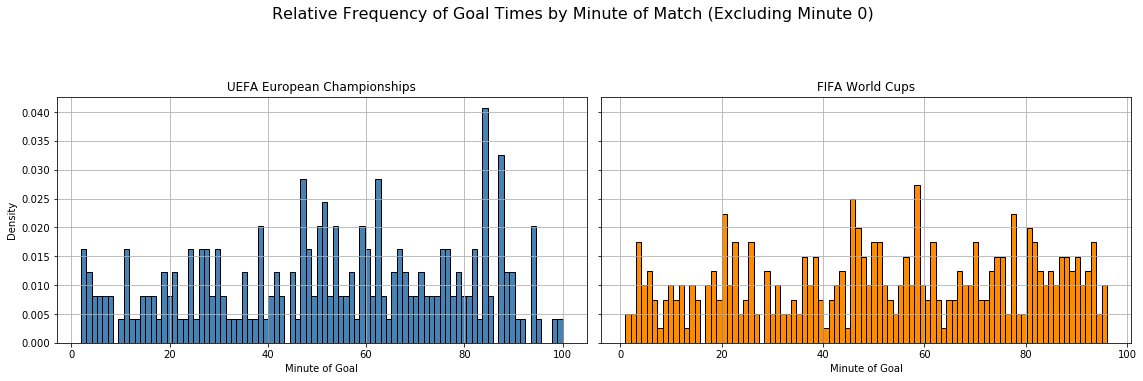

In [26]:
# Filter out zero-minute goals
goals_eu_uefa_filtered = goals_eu_uefa[goals_eu_uefa['goal_minute'] > 0]
goals_wc_fifa_filtered = goals_wc_fifa[goals_wc_fifa['goal_minute'] > 0]

# Plot setup
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# UEFA European Championships
axes[0].hist(goals_eu_uefa_filtered['goal_minute'], bins=90, density=True, color='steelblue', edgecolor='black')
axes[0].set_title('UEFA European Championships')
axes[0].set_xlabel('Minute of Goal')
axes[0].set_ylabel('Density')
axes[0].grid(True)

# FIFA World Cups
axes[1].hist(goals_wc_fifa_filtered['goal_minute'], bins=90, density=True, color='darkorange', edgecolor='black')
axes[1].set_title('FIFA World Cups')
axes[1].set_xlabel('Minute of Goal')
axes[1].grid(True)

# Add suptitle and adjust spacing
fig.suptitle('Relative Frequency of Goal Times by Minute of Match (Excluding Minute 0)', fontsize=16, y=1.05)
plt.tight_layout()
plt.subplots_adjust(top=0.8)  # Add more vertical spacing between suptitle and plots
plt.show()


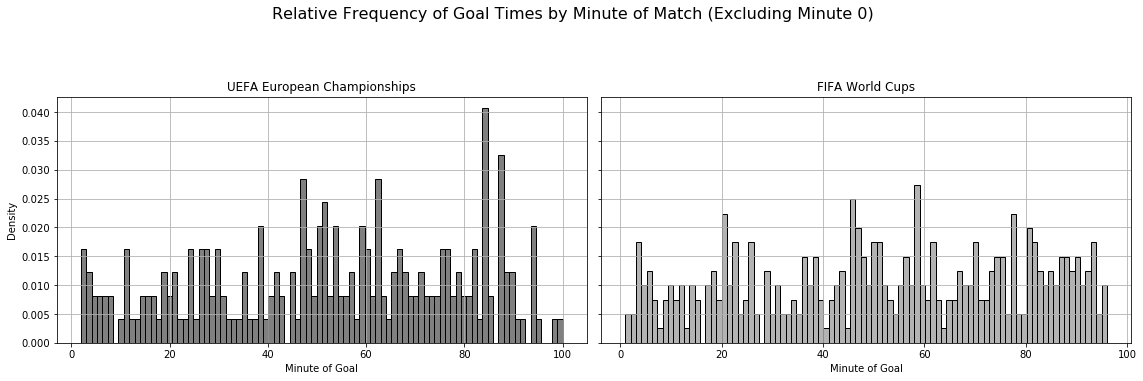

In [27]:
# Filter out zero-minute goals
goals_eu_uefa_filtered = goals_eu_uefa[goals_eu_uefa['goal_minute'] > 0]
goals_wc_fifa_filtered = goals_wc_fifa[goals_wc_fifa['goal_minute'] > 0]

# Plot setup
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# UEFA European Championships
axes[0].hist(goals_eu_uefa_filtered['goal_minute'], bins=90, density=True, 
             color='0.5', edgecolor='black')  # medium grey
axes[0].set_title('UEFA European Championships')
axes[0].set_xlabel('Minute of Goal')
axes[0].set_ylabel('Density')
axes[0].grid(True)

# FIFA World Cups
axes[1].hist(goals_wc_fifa_filtered['goal_minute'], bins=90, density=True, 
             color='0.7', edgecolor='black')  # lighter grey
axes[1].set_title('FIFA World Cups')
axes[1].set_xlabel('Minute of Goal')
axes[1].grid(True)

# Add suptitle and adjust spacing
fig.suptitle('Relative Frequency of Goal Times by Minute of Match (Excluding Minute 0)', 
             fontsize=16, y=1.05)
plt.tight_layout()
plt.subplots_adjust(top=0.8)  # Add more vertical spacing between suptitle and plots
plt.show()


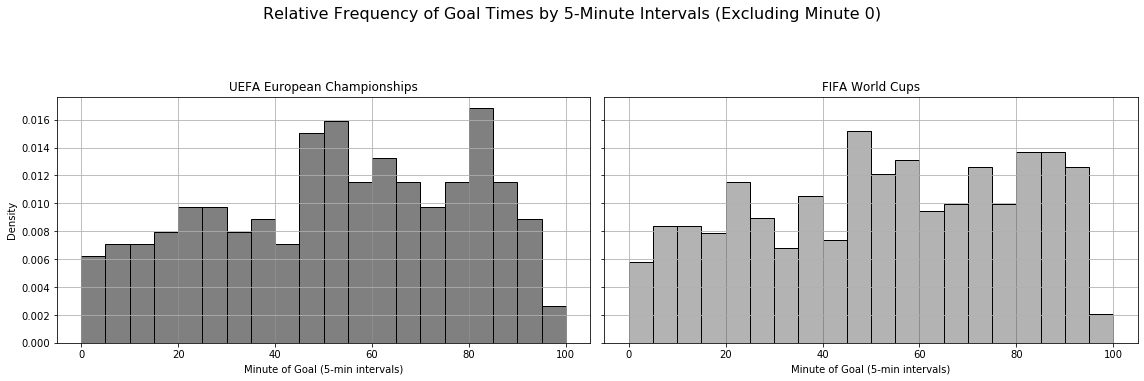

In [28]:
# Define 5-minute bins from 0 to 100
bins = list(range(0, 101, 5))

# Filter out zero-minute goals
goals_eu_uefa_filtered = goals_eu_uefa[goals_eu_uefa['goal_minute'] > 0]
goals_wc_fifa_filtered = goals_wc_fifa[goals_wc_fifa['goal_minute'] > 0]

# Plot setup
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# UEFA European Championships
axes[0].hist(goals_eu_uefa_filtered['goal_minute'], bins=bins, density=True,
             color='0.5', edgecolor='black')  # medium grey
axes[0].set_title('UEFA European Championships')
axes[0].set_xlabel('Minute of Goal (5-min intervals)')
axes[0].set_ylabel('Density')
axes[0].grid(True)

# FIFA World Cups
axes[1].hist(goals_wc_fifa_filtered['goal_minute'], bins=bins, density=True,
             color='0.7', edgecolor='black')  # lighter grey
axes[1].set_title('FIFA World Cups')
axes[1].set_xlabel('Minute of Goal (5-min intervals)')
axes[1].grid(True)

# Add suptitle and adjust spacing
fig.suptitle('Relative Frequency of Goal Times by 5-Minute Intervals (Excluding Minute 0)',
             fontsize=16, y=1.05)
plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.show()


## Suspense Trajectory Analysis (Stable vs Volatile Groups)

In [29]:
def plot_suspense_trajectory(goals_df, mbm_df, title="Suspense Trajectory"):
    """
    Plots suspense trajectories for 'Stable' vs 'Volatile' groups based on avg_qual_count.

    Parameters:
    - goals_df: DataFrame with group-level info (must include 'year', 'group', 'avg_qual_count')
    - mbm_df:   Minute-by-minute dataset (must include 'year', 'stage', 'match_minute', 'suspense')
    - title:    Title of the plot (string)

    Output:
    - A matplotlib plot showing average suspense trajectories by group volatility
    """
    
    # Define volatility threshold (median of qualification changes)
    volatility_threshold = goals_df['avg_qual_count'].median()
    goals_df = goals_df.copy()
    goals_df['volatility'] = goals_df['avg_qual_count'].apply(
        lambda x: 'Volatile' if x > volatility_threshold else 'Stable'
    )

    # Merge volatility classification into minute-level data
    mbm_merged = mbm_df.merge(
        goals_df[['year', 'group', 'volatility']].rename(columns={'group': 'stage'}),
        on=['year', 'stage'],
        how='left'
    )

    # Compute average suspense by minute and volatility type
    suspense_trajectory = (
        mbm_merged.groupby(['match_minute', 'volatility'])['suspense']
        .mean()
        .reset_index()
    )

    # Plot
    plt.figure(figsize=(10, 6))
    colors = {'Stable': '0.3', 'Volatile': '0.6'}  # greyscale

    for label, df_group in suspense_trajectory.groupby('volatility'):
        plt.plot(df_group['match_minute'], df_group['suspense'],
                 label=label, color=colors[label], linewidth=2)

    plt.title(title)
    plt.xlabel("Minute")
    plt.ylabel("Average Suspense")
    plt.legend(title="Group Type")
    plt.grid(True, linestyle="--", linewidth=0.5, color="0.8")
    plt.tight_layout()
    plt.show()


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


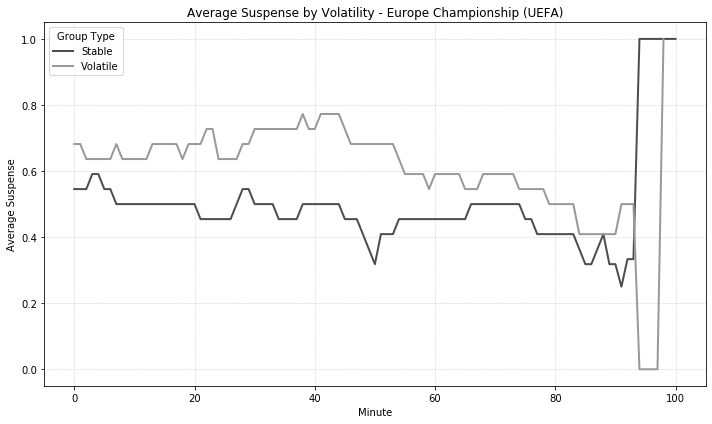

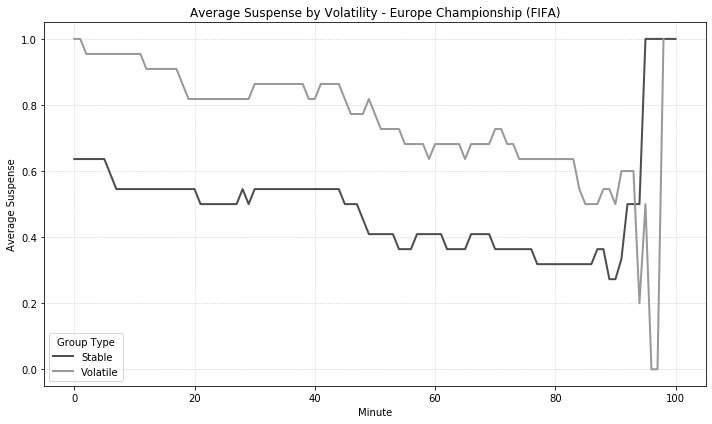

In [30]:
# UEFA example
plot_suspense_trajectory(agg_goals_eu_uefa, mbm_eu_uefa, title="Average Suspense by Volatility - Europe Championship (UEFA)")

# FIFA example
plot_suspense_trajectory(agg_goals_eu_fifa, mbm_eu_fifa, title="Average Suspense by Volatility - Europe Championship (FIFA)")


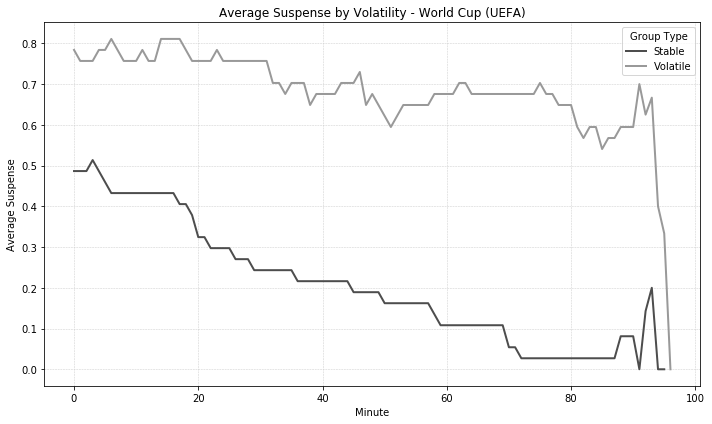

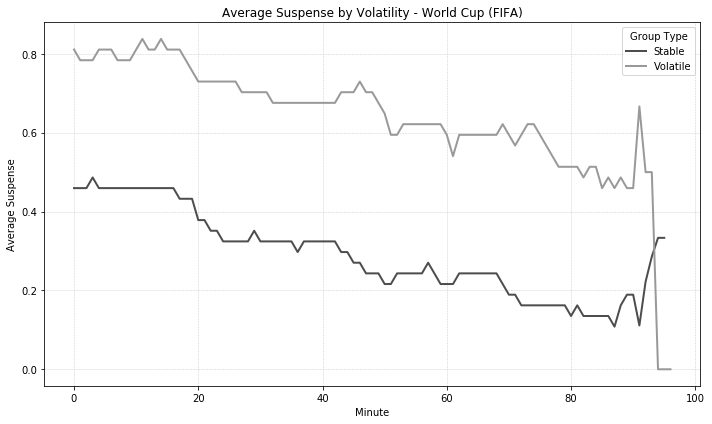

In [31]:
# UEFA example
plot_suspense_trajectory(agg_goals_wc_uefa, mbm_wc_uefa, title="Average Suspense by Volatility - World Cup (UEFA)")

# FIFA example
plot_suspense_trajectory(agg_goals_wc_fifa, mbm_wc_fifa, title="Average Suspense by Volatility - World Cup (FIFA)")


In this analysis, each minute-by-minute observation is labeled as belonging to either a "stable" or "volatile" group based on the average number of qualification changes (`avg_qual_count`) observed in its group (defined by year and stage). Groups with an `avg_qual_count` above the median are classified as volatile, while those below are considered stable. This classification is then merged into the minute-level dataset, allowing us to track how suspense evolves over time for the two types of groups. For each minute of play, we compute the average suspense separately for all observations in stable and volatile groups, creating two suspense trajectories.


## Avg suspense per minute UEFA vs FIFA

In [32]:
# Group and compute average suspense per minute
suspense_fifa = mbm_eu_fifa.groupby('match_minute')['suspense'].mean().reset_index(name='suspense_fifa')
suspense_uefa = mbm_eu_uefa.groupby('match_minute')['suspense'].mean().reset_index(name='suspense_uefa')

# Merge on match_minute
suspense_comparison = pd.merge(suspense_uefa, suspense_fifa, on='match_minute')


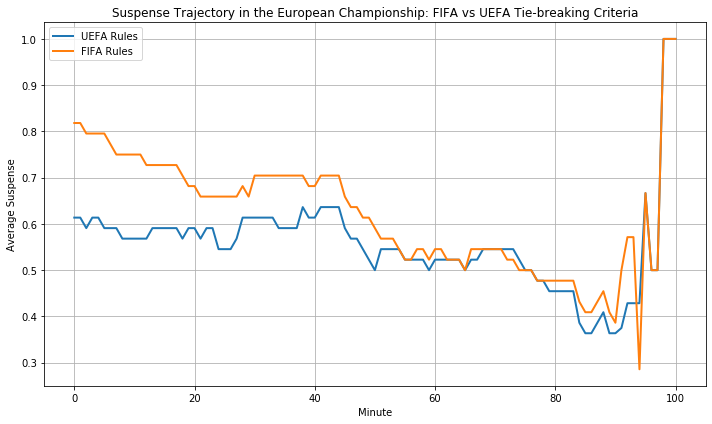

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(suspense_comparison['match_minute'], suspense_comparison['suspense_uefa'], label='UEFA Rules', linewidth=2)
plt.plot(suspense_comparison['match_minute'], suspense_comparison['suspense_fifa'], label='FIFA Rules', linewidth=2)
plt.xlabel('Minute')
plt.ylabel('Average Suspense')
plt.title('Suspense Trajectory in the European Championship: FIFA vs UEFA Tie-breaking Criteria')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


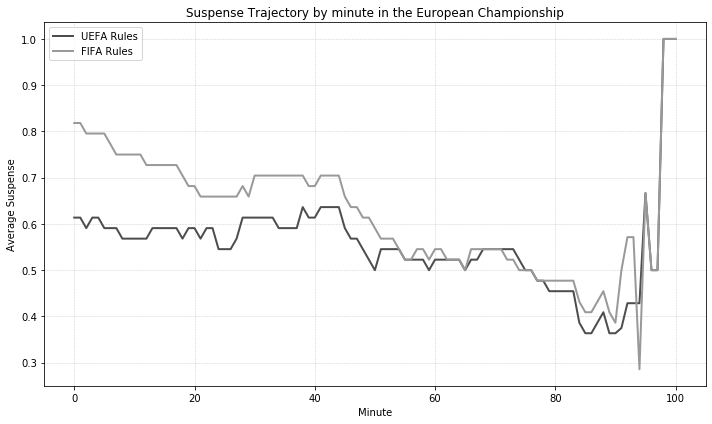

In [34]:
# Plot in greyscale
plt.figure(figsize=(10, 6))
plt.plot(
    suspense_comparison['match_minute'], suspense_comparison['suspense_uefa'],
    label='UEFA Rules', color='0.3', linewidth=2  
)
plt.plot(
    suspense_comparison['match_minute'], suspense_comparison['suspense_fifa'],
    label='FIFA Rules', color='0.6', linewidth=2
)

plt.xlabel('Minute')
plt.ylabel('Average Suspense')
plt.title('Suspense Trajectory by minute in the European Championship')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color='0.8')
plt.tight_layout()
plt.show()


In [35]:
# Group and compute average suspense per minute
suspense_fifa_wc = mbm_wc_fifa.groupby('match_minute')['suspense'].mean().reset_index(name='suspense_fifa')
suspense_uefa_wc = mbm_wc_uefa.groupby('match_minute')['suspense'].mean().reset_index(name='suspense_uefa')

# Merge on match_minute
suspense_comparison_wc = pd.merge(suspense_uefa_wc, suspense_fifa_wc, on='match_minute')



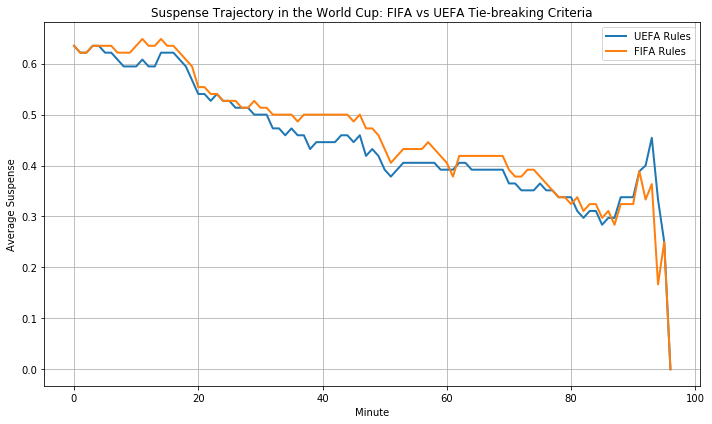

In [36]:

plt.figure(figsize=(10, 6))
plt.plot(suspense_comparison_wc['match_minute'], suspense_comparison_wc['suspense_uefa'], label='UEFA Rules', linewidth=2)
plt.plot(suspense_comparison_wc['match_minute'], suspense_comparison_wc['suspense_fifa'], label='FIFA Rules', linewidth=2)
plt.xlabel('Minute')
plt.ylabel('Average Suspense')
plt.title('Suspense Trajectory in the World Cup: FIFA vs UEFA Tie-breaking Criteria')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

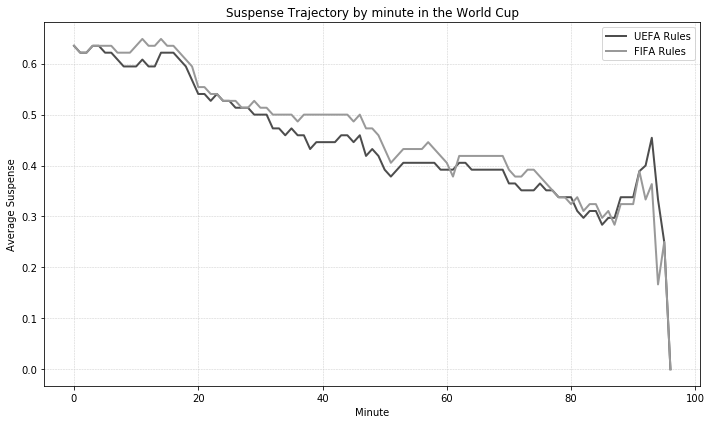

In [37]:
# Plot in greyscale
plt.figure(figsize=(10, 6))
plt.plot(
    suspense_comparison_wc['match_minute'], suspense_comparison_wc['suspense_uefa'],
    label='UEFA Rules', color='0.3', linewidth=2  
)
plt.plot(
    suspense_comparison_wc['match_minute'], suspense_comparison_wc['suspense_fifa'],
    label='FIFA Rules', color='0.6', linewidth=2
)

plt.xlabel('Minute')
plt.ylabel('Average Suspense')
plt.title('Suspense Trajectory by minute in the World Cup')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color='0.8')
plt.tight_layout()
plt.show()


# Suspense, Surpise, Shock as defined in literature 

In [39]:
# Remove rows where all three sss_columns are zero
sss_columns = ['shock', 'surprise', 'suspense']
sss_eu = sss_eu[~((sss_eu[sss_columns] == 0).all(axis=1))]


In [40]:
# Group and compute aggregate metrics
sss_eu_agg = sss_eu.groupby(['year', 'stage']).agg(
    avg_suspense=('suspense', 'mean'), 
    avg_surprise=('surprise', 'mean'), 
    avg_shock=('shock', 'mean'), 
).reset_index()

In [41]:
# Group and compute aggregate metrics
sss_wc_agg = sss_wc.groupby(['year', 'stage']).agg(
    avg_suspense=('suspense', 'mean'), 
    avg_surprise=('surprise', 'mean'), 
    avg_shock=('shock', 'mean'), 
).reset_index()

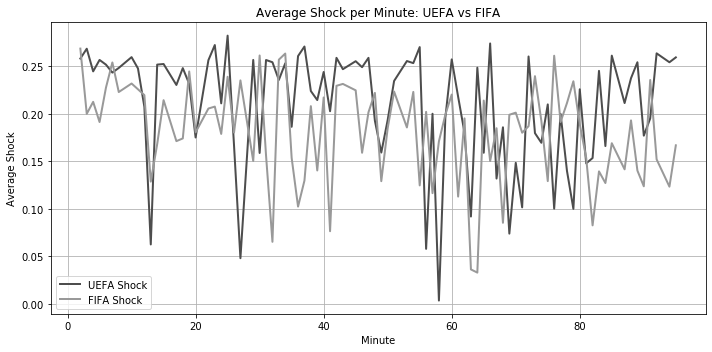

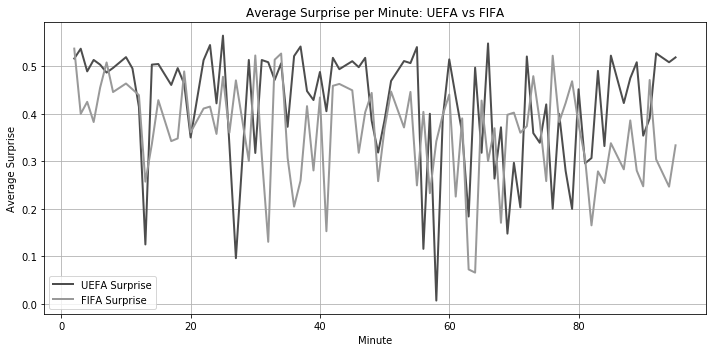

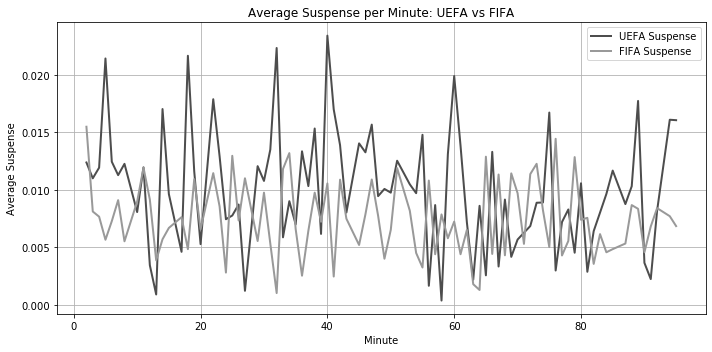

In [ ]:
# Group and compute average values per minute
suspense_uefa = sss_eu.groupby('minute')['suspense'].mean().reset_index(name='suspense_uefa')
shock_uefa = sss_eu.groupby('minute')['shock'].mean().reset_index(name='shock_uefa')
surprise_uefa = sss_eu.groupby('minute')['surprise'].mean().reset_index(name='surprise_uefa')

suspense_fifa = sss_wc.groupby('minute')['suspense'].mean().reset_index(name='suspense_fifa')
shock_fifa = sss_wc.groupby('minute')['shock'].mean().reset_index(name='shock_fifa')
surprise_fifa = sss_wc.groupby('minute')['surprise'].mean().reset_index(name='surprise_fifa')

# Merge separately for each variable
shock_df = pd.merge(shock_uefa, shock_fifa, on='minute')
surprise_df = pd.merge(surprise_uefa, surprise_fifa, on='minute')
suspense_df = pd.merge(suspense_uefa, suspense_fifa, on='minute')

# Plot Shock
plt.figure(figsize=(10, 5))
plt.plot(shock_df['minute'], shock_df['shock_uefa'], label='UEFA Shock',color = '0.3', linewidth=2)
plt.plot(shock_df['minute'], shock_df['shock_fifa'], label='FIFA Shock', color = '0.6', linewidth=2)
plt.title('Average Shock per Minute: UEFA vs FIFA')
plt.xlabel('Minute')
plt.ylabel('Average Shock')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Surprise
plt.figure(figsize=(10, 5))
plt.plot(surprise_df['minute'], surprise_df['surprise_uefa'], label='UEFA Surprise', color = '0.3', linewidth=2)
plt.plot(surprise_df['minute'], surprise_df['surprise_fifa'], label='FIFA Surprise', color = '0.6', linewidth=2)
plt.title('Average Surprise per Minute: UEFA vs FIFA')
plt.xlabel('Minute')
plt.ylabel('Average Surprise')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Suspense
plt.figure(figsize=(10, 5))
plt.plot(suspense_df['minute'], suspense_df['suspense_uefa'], label='UEFA Suspense', color = '0.3', linewidth=2)
plt.plot(suspense_df['minute'], suspense_df['suspense_fifa'], label='FIFA Suspense', color = '0.6', linewidth=2)
plt.title('Average Suspense per Minute: UEFA vs FIFA')
plt.xlabel('Minute')
plt.ylabel('Average Suspense')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
